# Лабораторная работа 3. Полиномиальная регрессия. Регуляризация

### Задание 1. Полиномиальная регрессия

Загрузите данные из файлов `ml_lab1_train.txt` и `ml_lab1_test.txt` (первая лабораторная работа).

Для $k = 1,2,3,\ldots,10$ найдите полином ${f}_k$ степени $k$, наилучшим образом приближающий неизвестную зависимость.

Выведите коэффициенты полиномов и нарисуйте их графики на одном чертеже вместе с точками данных $(x_i, y_i)$ (возможно, чертеж стоит сделать побольше; это делается командой `plt.figure(figsize=(width, height))`).

Для каждого из полиномов найдите среднеквадратическую ошибку $MSE$ и коэффициент детерминации $R^2$ на обучающих данных и на тестовых данных. Постройте графики зависимости $MSE$ на обучающих и тестовых данных в зависимости от степени полинома (должно быть три графика: один для обучающих данных, второй – для тестовых, третий – для обоих видов данных вместе).

Сделайте вывод, что происходит с ошибкой на обучающих и тестовых данных с увеличением степени полинома.

In [394]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


def find_polynomial_coefficients(train_data, polynomial_degree):
    X = np.array([train_data["x"] ** i for i in range(polynomial_degree + 1)]).T
    y = np.array(train_data["y"])
    coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
    return coefficients

def find_polynomial_regression(x, coefficients):
    return np.array([sum([coefficients[i] * x_i ** i for i in range(len(coefficients))]) for x_i in x])


In [395]:
train_data = pd.read_csv('ml_lab1_train.txt', header=None, names=['x', 'y'])
test_data = pd.read_csv('ml_lab1_test.txt', header=None, names=['x', 'y'])

max_k = 10
x_min = np.concatenate((train_data['x'], test_data['x'])).min()
x_max = np.concatenate((train_data['x'], test_data['x'])).max()

mse_train_values = []
mse_test_values = []

k = 1, coefficients = [4.43323091 2.2791345 ]
MSE for train data with k = 1: 0.2968966332625196
MSE for test data with k = 1: 0.4351202004048882
R2 for train data with k = 1: 0.6978349896117897
R2 for test data with k = 1: 0.6848801332179667
k = 2, coefficients = [4.4724765  1.15783169 1.40162851]
MSE for train data with k = 2: 0.2696989158766914
MSE for test data with k = 2: 0.35647628878312104
R2 for train data with k = 2: 0.7255153255796204
R2 for test data with k = 2: 0.7418351055001289
k = 3, coefficients = [ 4.46073636  1.06501611  1.85975084 -0.3817686 ]
MSE for train data with k = 3: 0.26949718714796106
MSE for test data with k = 3: 0.35534645715183033
R2 for train data with k = 3: 0.7257206339482016
R2 for test data with k = 3: 0.7426533446735968
k = 4, coefficients = [  4.34116612   1.17180239   6.79409178 -13.05132812   7.9184747 ]
MSE for train data with k = 4: 0.2610665330579276
MSE for test data with k = 4: 0.4417270189284551
R2 for train data with k = 4: 0.73430088847214

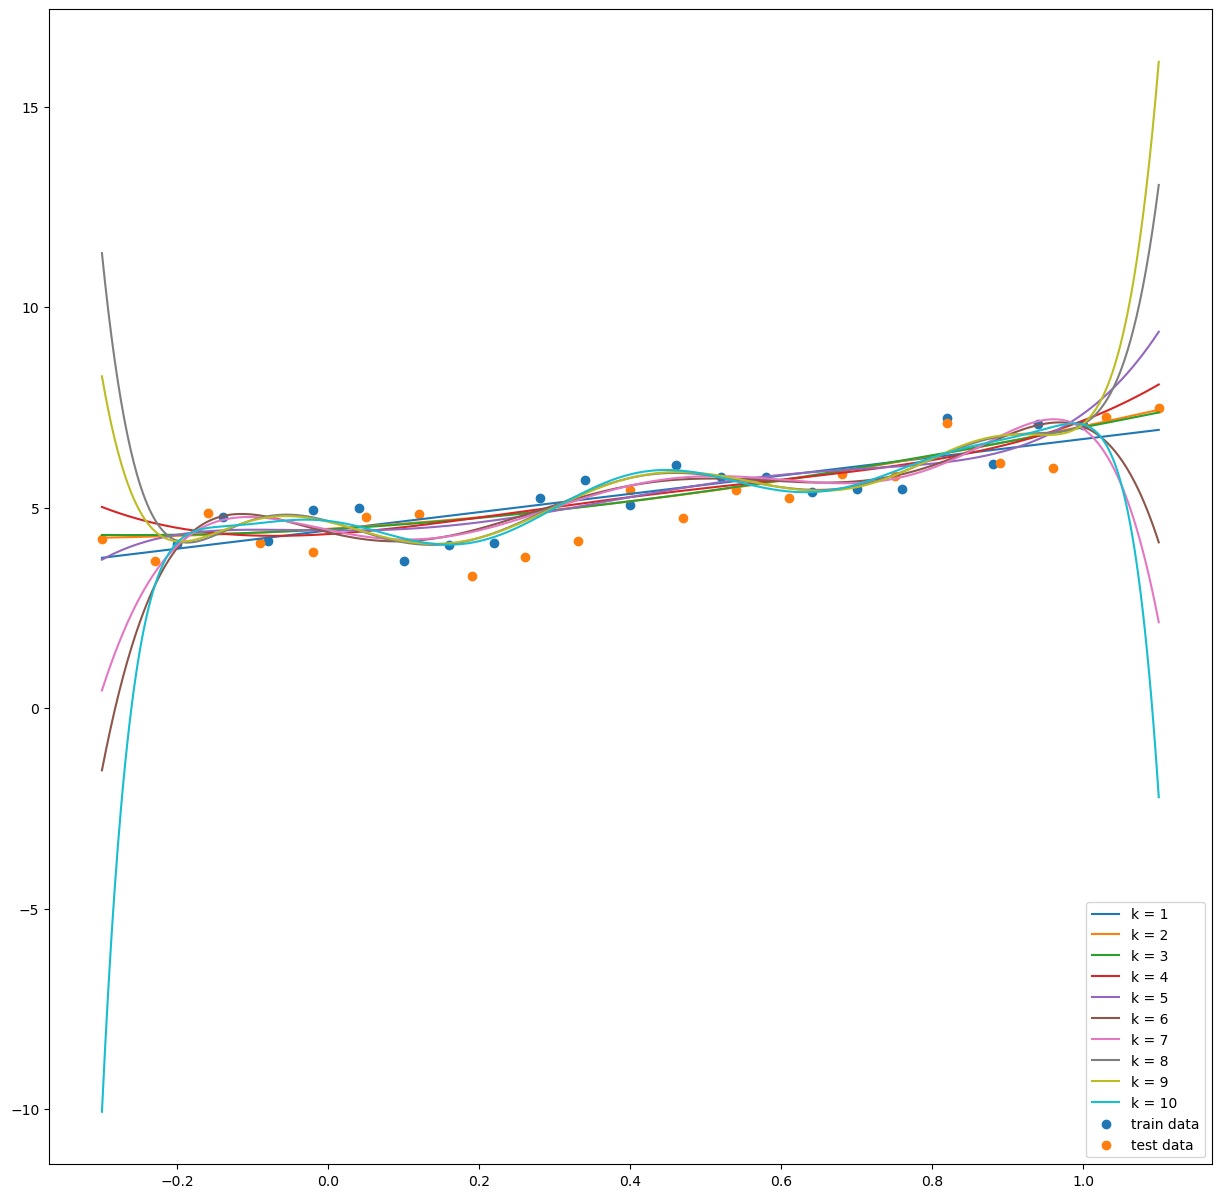

In [396]:
plt.figure(figsize=(15, 15))

for k in range(1, max_k + 1):
    coefficients = find_polynomial_coefficients(train_data, k)
    print(f'k = {k}, coefficients = {coefficients}')
    
    x = np.linspace(x_min, x_max, 1000)
    y = find_polynomial_regression(x, coefficients)
    
    mse_train = mean_squared_error(train_data['y'], find_polynomial_regression(train_data['x'], coefficients))
    mse_test = mean_squared_error(test_data['y'], find_polynomial_regression(test_data['x'], coefficients))
    print(f"MSE for train data with k = {k}: {mse_train}")
    print(f"MSE for test data with k = {k}: {mse_test}")
    mse_train_values.append(mse_train)
    mse_test_values.append(mse_test)
    
    r2_train = r2_score(train_data['y'], find_polynomial_regression(train_data['x'], coefficients))
    r2_test = r2_score(test_data['y'], find_polynomial_regression(test_data['x'], coefficients))
    print(f"R2 for train data with k = {k}: {r2_train}")
    print(f"R2 for test data with k = {k}: {r2_test}")
    
    plt.plot(x, y, label=f'k = {k}')

plt.scatter(train_data['x'], train_data['y'], label='train data')
plt.scatter(test_data['x'], test_data['y'], label='test data')
plt.legend()
plt.savefig('polynomial_regression.png')

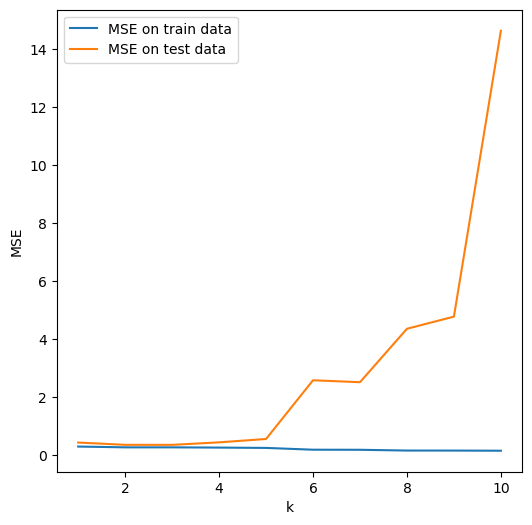

In [397]:
plt.figure(figsize=(6, 6))
plt.plot(range(1, max_k + 1), mse_train_values, label='MSE on train data')
plt.plot(range(1, max_k + 1), mse_test_values, label='MSE on test data')
plt.legend()
plt.xlabel('k')
plt.ylabel('MSE')
plt.show()

### Задание 2. Регуляризация

Вспомним, что задачу линейной регрессии (нахождение вектора коэффициентов $\overrightarrow{w}_{opt}$) можно решить при помощи нормального уравнения:

$$\overrightarrow{w}_{opt} = \left(X^TX\right)^{-1}X^T\overrightarrow{y}.$$

Если строки или столбцы матрицы $X$ линейно зависимы, то матрица $X^TX$ вырожденна и задача не может быть решена с помощью нормального уравнения (придется использовать, например, градиентный спуск). На практике различные признаки редко бывают *в точности* линейно зависимы, однако во многих ситуациях они скоррелированы и становятся "почти" линейно зависимыми. Таковы, к примеру, зарплата человека, его уровень образования, цена машины и суммарная площадь недвижимости, которой он владеет. В этом случае матрица $X^TX$ будет близка к вырожденной, и это приводит к численной неустойчивости и плохому качеству решений; как следствие, будет иметь место *переобучение* (overfitting). Один из симптомов этой проблемы – необычно большие по модулю компоненты вектора $\overrightarrow{w}_{opt}$.

Один из способов борьбы с переобучением – **регуляризация**. Сейчас мы рассмотрим одну из её разновидностей – **L2-регуляризацию**. Идея в том, чтобы подправить матрицу $X^TX$, сделав её "получше". Например, это можно сделать, заменив её на $(X^TX + \alpha I)$, где $\alpha$ – параметр регуляризации, $I$ – единичная матрица. Пожертвовав точностью на обучающей выборке, мы тем не менее получаем численно более стабильное псевдорешение:

$$\overrightarrow{w}_{opt} = (X^TX + \alpha I)^{-1}X^T\overrightarrow{y}$$

и снижаем эффект переобучения. Параметр $\alpha$ нужно подбирать, и каких-то универсальных способов это делать нет, но зачастую можно его подобрать таким, чтобы ошибка на тестовой выборке падала. 

Теперь давайте вспомним первую задачу. Если вы её сделали, то помните, что ошибка аппроксимации полиномом шестой степени довольно высокая. Убедитесь, что, используя регуляризацию с хорошо подобранным параметром $\alpha$, ошибку на тестовой выборке можно сделать не больше, чем для полинома оптимальной степени в модели без регуляризации. Для этого $\alpha$ сравните $\det(X^TX)$ и $\det(X^TX + \alpha I)$.

Изобразите на графике три полинома: полином оптимальной степени без регуляризации, полином шестой степени без регуляризации и полином шестой степени с регуляризацией.

In [398]:
def add_ones(X):
    X = np.array(X)

    ones = np.ones((X.shape[0], 1))
    return np.concatenate((ones, X), axis = 1)

def get_weights_using_normal_equation_with_regularization(X, y, a):
    X = np.array(X)
    y = np.array(y)

    if X.ndim == 1:
        X = X[:, np.newaxis]

    X = add_ones(X)
    X_transposed = np.transpose(X)

    aI = np.diag([0.0001 * a] * X.shape[1])
    
    print(f"det of X_T * X = {np.linalg.det(np.dot(X_transposed, X))}")
    print(f"det of X_T * X + aI = {np.linalg.det(np.dot(X_transposed, X) + aI)}")

    w = np.linalg.inv(X_transposed @ X + aI) @ X_transposed @ y
    return w

def y_predict(X, w):
    X = np.array(X)

    if X.ndim == 1:
        X = X[:, np.newaxis]

    return np.dot(add_ones(X), w)

In [399]:
mse = []
for a in range(0, 100000):
    w = get_weights_using_normal_equation_with_regularization(train_data['x'], train_data['y'], a)
    mse.append(mean_squared_error(test_data['y'], y_predict(test_data['x'], w)))
mse = np.array(mse)

det of X_T * X = 58.212
det of X_T * X + aI = 58.212
det of X_T * X = 58.212
det of X_T * X + aI = 58.214713209999964
det of X_T * X = 58.212
det of X_T * X + aI = 58.21742643999997
det of X_T * X = 58.212
det of X_T * X + aI = 58.22013969000002
det of X_T * X = 58.212
det of X_T * X + aI = 58.22285295999996
det of X_T * X = 58.212
det of X_T * X + aI = 58.22556624999997
det of X_T * X = 58.212
det of X_T * X + aI = 58.228279559999955
det of X_T * X = 58.212
det of X_T * X + aI = 58.23099288999996
det of X_T * X = 58.212
det of X_T * X + aI = 58.23370624000001
det of X_T * X = 58.212
det of X_T * X + aI = 58.23641961000001
det of X_T * X = 58.212
det of X_T * X + aI = 58.23913299999999
det of X_T * X = 58.212
det of X_T * X + aI = 58.241846409999994
det of X_T * X = 58.212
det of X_T * X + aI = 58.244559839999994
det of X_T * X = 58.212
det of X_T * X + aI = 58.24727328999996
det of X_T * X = 58.212
det of X_T * X + aI = 58.24998675999996
det of X_T * X = 58.212
det of X_T * X + aI = 5

In [400]:
print(f"best alpha is {0.0001 * mse.argmin()}, that has mse on test data = {mse.min()}")
w = get_weights_using_normal_equation_with_regularization(train_data['x'], train_data['y'], mse.argmin())

best alpha is 0.8423, that has mse on test data = 0.4032600858301607
det of X_T * X = 58.212
det of X_T * X + aI = 81.77475289


In [401]:
def find_polynomial_coefficients_with_regularization(train_data, polynomial_degree, a):
    X = np.array([train_data["x"] ** i for i in range(polynomial_degree + 1)]).T
    y = np.array(train_data["y"])

    aI = np.diag([0.0001 * a] * X.shape[1])
    
    coefficients = np.linalg.inv(X.T @ X + aI) @ X.T @ y
    return coefficients

mse for optimal_polynomial_regression_no_regularization = 0.35534645715183033
mse for sixth_degree_polynomial_regression_no_regularization = 2.5816929331951814
mse for sixth_degree_polynomial_regression_with_regularization = 0.3109395318088766


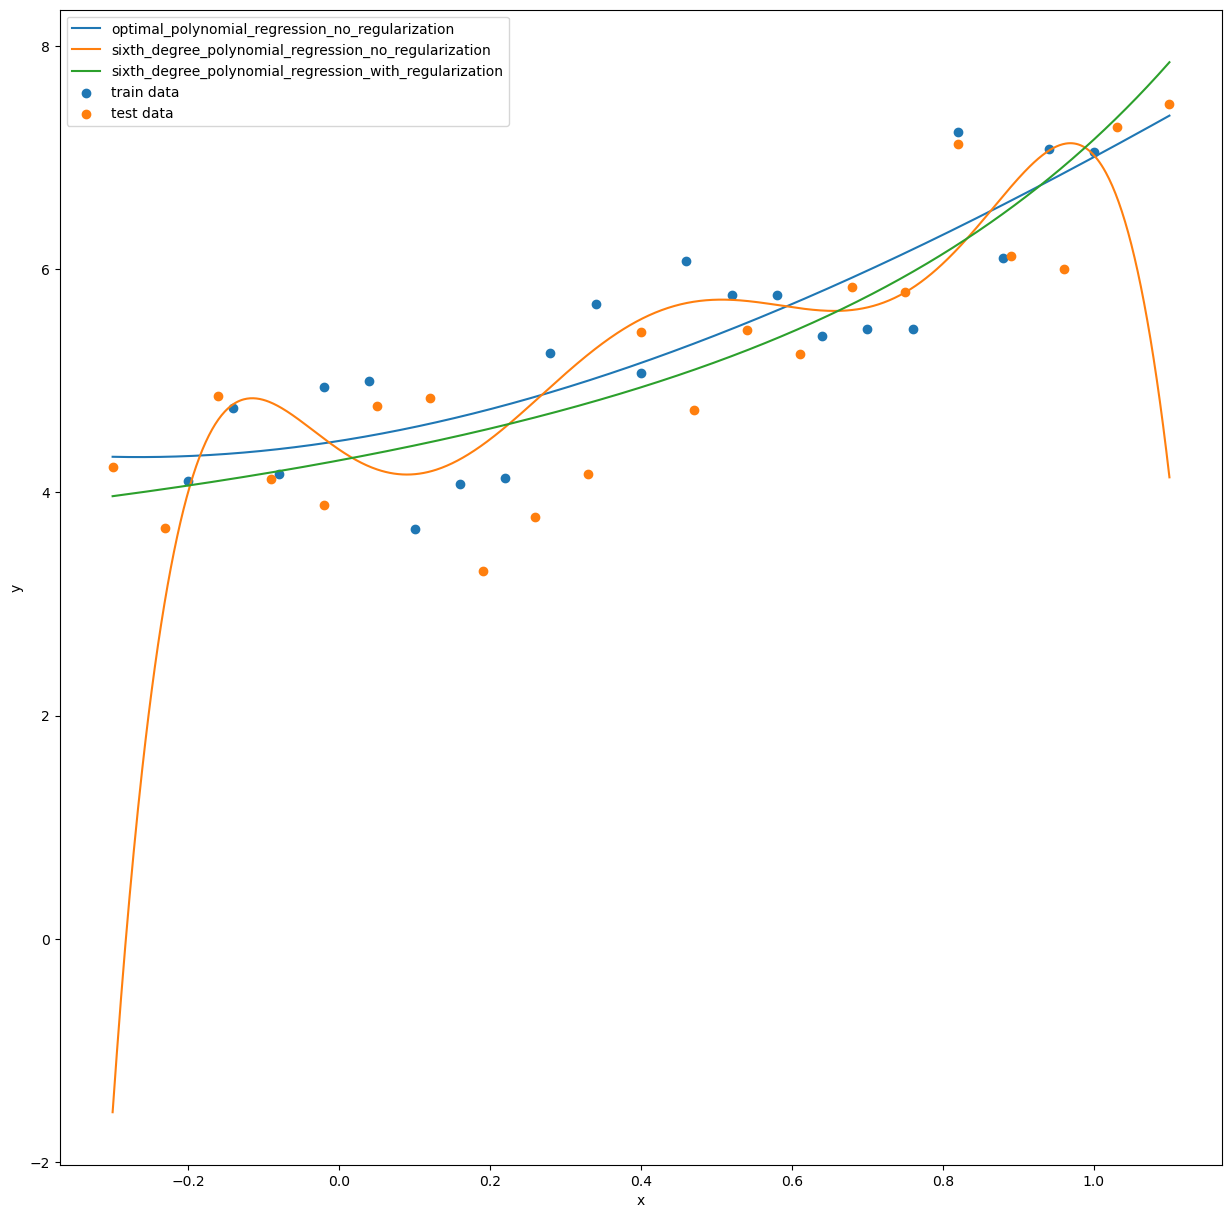

In [402]:
x = np.linspace(x_min, x_max, 1000)

coefs = find_polynomial_coefficients(train_data, 3)
optimal_polynomial_regression_no_regularization = find_polynomial_regression(x, coefs)
print(f"mse for optimal_polynomial_regression_no_regularization = {mean_squared_error(test_data['y'], find_polynomial_regression(test_data['x'], coefs))}")

coefs = find_polynomial_coefficients(train_data, 6)
sixth_degree_polynomial_regression_no_regularization = find_polynomial_regression(x, coefs)
print(f"mse for sixth_degree_polynomial_regression_no_regularization = {mean_squared_error(test_data['y'], find_polynomial_regression(test_data['x'], coefs))}")

coefs = find_polynomial_coefficients_with_regularization(train_data, 6, mse.argmin())
sixth_degree_polynomial_regression_with_regularization = find_polynomial_regression(x, coefs)
print(f"mse for sixth_degree_polynomial_regression_with_regularization = {mean_squared_error(test_data['y'], find_polynomial_regression(test_data['x'], coefs))}")

plt.figure(figsize=(15, 15))

plt.plot(x, optimal_polynomial_regression_no_regularization, label='optimal_polynomial_regression_no_regularization')
plt.plot(x, sixth_degree_polynomial_regression_no_regularization, label='sixth_degree_polynomial_regression_no_regularization')
plt.plot(x, sixth_degree_polynomial_regression_with_regularization, label='sixth_degree_polynomial_regression_with_regularization')
plt.scatter(train_data['x'], train_data['y'], label="train data")
plt.scatter(test_data['x'], test_data['y'], label="test data")

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Задание 3. Линейная регрессия в scikit-learn

Скачайте файлы ``flats_moscow.txt`` и ``flats_moscow_description.pdf``. В первом из них содержатся данные о квартирах в Москве. Каждая строка содержит шесть характеристик некоторой квартиры, разделённые знаками табуляции; в первой строке записаны кодовые названия характеристик. Во втором файле приведены краткие описания признаков. Вашей задачей будет построить с помощью линейной регрессии зависимость между ценой квартиры и остальными доступными параметрами.

Построив несколько моделей, нужно сравнить их качество. Проверять это на той же выборке, на которой вы обучались, бессмысленно и даже вредно (вспомните пример с полиномами: как хорошо падала ошибка на обучающей выборке с ростом степени и как быстро росла ошибка на тестовых данных!). Поэтому вам нужно будет разделить выборку на обучающую и тестовую. Делать это лучше случайным образом (ведь вы не знаете, как создатели набора данных упорядочили объекты); рекомендуем вам для этого функцию `sklearn.model_selection.train_test_split`.

Постройте следующие модели линейной регрессии по методу наименьших квадратов:

1. на основе собственной функции (нормальное уравнение);

1. с L2-регуляризацией на основе собственной функции – параметр регуляризации нужно подобрать;

1. собственную реализацию полиномиальной регрессии – степень полинома нужно подобрать;

1. на основе функции `LinearRegression` из `scikit-learn`;

1. с L2-регуляризацией на основе функции `Ridge` из `scikit-learn` – параметр регуляризации нужно подобрать;

1. с L1-регуляризацией на основе функции `Lasso` из `scikit-learn` – параметр регуляризации нужно подобрать.

Выведите и сравните регрессионные коэффициенты для всех функций. Какой смысл имеют их знаки? Согласуются ли они с вашими представлениями о жизни?

Оцените качество решения задачи, выведя среднеквадратическую ошибку на обучающих и тестовых данных для всех функций. Эти ошибки лучше свести в таблицу (например, используя `pandas.DataFrame`).

In [403]:
flats_data = pd.read_csv('flats_moscow.txt', header=0, delimiter="\t", dtype=np.float64)
flats_data.reset_index(inplace=True, drop=True)
flats_data

price  totsp  livesp  kitsp  dist  metrdist
0      81.0   58.0    40.0    6.0  12.5       7.0
1      75.0   44.0    28.0    6.0  13.5       7.0
2     128.0   70.0    42.0    6.0  14.5       3.0
3      95.0   61.0    37.0    6.0  13.5       7.0
4     330.0  104.0    60.0   11.0  10.5       7.0
...     ...    ...     ...    ...   ...       ...
2035  110.0   77.0    45.0   10.0  12.0       5.0
2036   95.0   60.0    43.0    6.0   9.0       5.0
2037   95.0   60.0    46.0    5.0  10.5       5.0
2038  129.0   76.0    48.0   10.0  12.5       5.0
2039  103.0   64.0    45.0    7.0  15.5       5.0

[2040 rows x 6 columns]

In [404]:
flats_y = flats_data['price']
flats_x = flats_data[["totsp", "livesp", "kitsp", "dist", "metrdist"]]

In [405]:
x, x_test, y, y_test = train_test_split(flats_x, flats_y, test_size = 0.2, train_size = 0.8, random_state = 42)
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size = 0.25, train_size = 0.75, random_state = 42)

x_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

x_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

x_validation.reset_index(inplace=True, drop=True)
y_validation.reset_index(inplace=True, drop=True)

In [433]:
mse_df = pd.DataFrame(data=None, columns=['method', 'MSE', 'alpha', 'polynomial degree'])
mse_df_index = 0
mse_df

Empty DataFrame
Columns: [method, MSE, alpha, polynomial degree]
Index: []

In [434]:
w = get_weights_using_normal_equation_with_regularization(x_train, y_train, 0)
print(f"weights: {w}")
normal_equation_MSE = mean_squared_error(y_test, y_predict(x_test, w))
print(f"MSE for linear regression is {normal_equation_MSE}")
mse_df.at[mse_df_index, "method"] = "linear regression"
mse_df.at[mse_df_index, "MSE"] = normal_equation_MSE
mse_df_index += 1

det of X_T * X = 8.49206653179491e+27
det of X_T * X + aI = 8.49206653179491e+27
weights: [14.76880588  2.51838277 -0.2253923   1.39117493 -3.2355205  -1.26595627
 -1.16083081]
MSE for linear regression is 1244.0890766332886


method          MSE alpha polynomial degree
0  linear regression  1244.089077   NaN               NaN

In [407]:
mse = []
for a in range(0, 10):
    w = get_weights_using_normal_equation_with_regularization(x_train, y_train, a)
    mse.append(mean_squared_error(y_validation, y_predict(x_validation, w)))
mse = np.array(mse)

det of X_T * X = 4.318290694427195e+24
det of X_T * X + aI = 4.318290694427195e+24
det of X_T * X = 4.318290694427195e+24
det of X_T * X + aI = 4.3183130532836355e+24
det of X_T * X = 4.318290694427195e+24
det of X_T * X + aI = 4.318335412142621e+24
det of X_T * X = 4.318290694427195e+24
det of X_T * X + aI = 4.3183577710038134e+24
det of X_T * X = 4.318290694427195e+24
det of X_T * X + aI = 4.318380129867211e+24
det of X_T * X = 4.318290694427195e+24
det of X_T * X + aI = 4.318402488732782e+24
det of X_T * X = 4.318290694427195e+24
det of X_T * X + aI = 4.3184248476005557e+24
det of X_T * X = 4.318290694427195e+24
det of X_T * X + aI = 4.318447206470746e+24
det of X_T * X = 4.318290694427195e+24
det of X_T * X + aI = 4.3184695653430755e+24
det of X_T * X = 4.318290694427195e+24
det of X_T * X + aI = 4.318491924217666e+24


In [435]:
mse.argmin()
mse_df.at[mse_df_index, "method"] = "custom l2 regularization"
mse_df.at[mse_df_index, "MSE"] = normal_equation_MSE
mse_df_index += 1

In [436]:
mse_df

method          MSE alpha polynomial degree
0  custom l2 regularization  1244.089077   NaN               NaN

In [409]:
from sklearn.preprocessing import PolynomialFeatures

def find_multivariate_polynomial_coefficients(x_train, y_train, polynomial_degree):
    poly = PolynomialFeatures(polynomial_degree)
    
    X = np.array(poly.fit_transform(x_train))
    y = np.array(y_train)
    coefficients = np.linalg.inv(X.T @ X) @ X.T @ y
    
    return coefficients

def find_multivariate_polynomial_regression(x, coefficients, polynomial_degree):
    poly = PolynomialFeatures(polynomial_degree)
    
    x = poly.fit_transform(x)
    return np.dot(x, coefficients)

In [410]:
mse = []
for k in range(1, 10):
    coefs = find_multivariate_polynomial_coefficients(x_train, y_train, k)
    y_predicted = find_multivariate_polynomial_regression(x_validation, coefs, k)
    mse.append(mean_squared_error(y_validation, y_predicted))
mse = np.array(mse)

In [411]:
optimal_k = mse.argmin() + 1
optimal_k

2

In [412]:
coefs = find_multivariate_polynomial_coefficients(x_train, y_train, optimal_k)
y_predicted = find_multivariate_polynomial_regression(x_test, coefs, optimal_k)
print(f"MSE for polynomial regression with degree of poly = {optimal_k} is {mean_squared_error(y_test, y_predicted)}")
mse_df.at[mse_df_index, "method"] = "polynomial regression"
mse_df.at[mse_df_index, "MSE"] = mean_squared_error(y_test, y_predicted)
mse_df.at[mse_df_index, "polynomial degree"]
mse_df_index += 1

MSE for polynomial regression with degree of poly = 2 is 1104.6402942830948


In [413]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train, y_train)
reg.intercept_

-14.659677537757645

In [414]:
reg.coef_

array([ 1.45628649,  1.24325067,  2.6569982 , -3.20953018, -1.2906214 ])

In [415]:
flats_data

price  totsp  livesp  kitsp  dist  metrdist
0      81.0   58.0    40.0    6.0  12.5       7.0
1      75.0   44.0    28.0    6.0  13.5       7.0
2     128.0   70.0    42.0    6.0  14.5       3.0
3      95.0   61.0    37.0    6.0  13.5       7.0
4     330.0  104.0    60.0   11.0  10.5       7.0
...     ...    ...     ...    ...   ...       ...
2035  110.0   77.0    45.0   10.0  12.0       5.0
2036   95.0   60.0    43.0    6.0   9.0       5.0
2037   95.0   60.0    46.0    5.0  10.5       5.0
2038  129.0   76.0    48.0   10.0  12.5       5.0
2039  103.0   64.0    45.0    7.0  15.5       5.0

[2040 rows x 6 columns]

In [416]:
print(f"MSE for scikit learn Linear Regression: {mean_squared_error(y_test, reg.predict(x_test))}")

MSE for scikit learn Linear Regression: 1231.7112345074254


In [417]:
from sklearn import linear_model

mse = []
for a in range(10000):
    ridge_model = linear_model.Ridge(alpha = 0.01 * a)
    ridge_model.fit(x_train, y_train)
    mse.append(mean_squared_error(y_validation, ridge_model.predict(x_validation)))
mse = np.array(mse)

In [418]:
ridge_model = linear_model.Ridge(alpha = 0.01 * mse.argmin())
ridge_model.fit(x_train, y_train)
print(f"MSE for ridge regression is: {mean_squared_error(y_test, ridge_model.predict(x_test))}")

MSE for ridge regression is: 1230.9949354985545


In [419]:
mse = []
for a in range(10000):
    lasso_model = linear_model.Lasso(alpha = 0.01 * a)
    lasso_model.fit(x_train, y_train)
    mse.append(mean_squared_error(y_validation, lasso_model.predict(x_validation)))
mse = np.array(mse)

C:\Users\bred7\AppData\Local\Temp\ipykernel_15828\3655243045.py:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model.fit(x_train, y_train)
C:\Users\bred7\anaconda3\envs\lab_3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\bred7\anaconda3\envs\lab_3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.325e+05, tolerance: 2.972e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.en

In [420]:
lasso_model = linear_model.Lasso(alpha = 0.01 * mse.argmin())
lasso_model.fit(x_train, y_train)
print(f"MSE for lasso regression is: {mean_squared_error(y_test, lasso_model.predict(x_test))}")

MSE for lasso regression is: 1231.711234507426


C:\Users\bred7\AppData\Local\Temp\ipykernel_15828\1830067367.py:2: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso_model.fit(x_train, y_train)
C:\Users\bred7\anaconda3\envs\lab_3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\bred7\anaconda3\envs\lab_3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.325e+05, tolerance: 2.972e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.en

Конечно, никто не гарантирует, что объясняемая переменная (цена квартиры) зависит от остальных характеристик именно линейно. Зависимость может быть, например, квадратичной или логарифмической; больше того, могут быть важны не только отдельные признаки, но и их комбинации. Это можно учитывать, добавляя в качестве дополнительных признаков разные функции от уже имеющихся характеристик: их квадраты, логарифмы, попарные произведения.

В этом задании вам нужно постараться улучшить качество модели, добавляя дополнительные признаки (не менее трёх), являющиеся функциями от уже имеющихся. Но будьте осторожны: чрезмерное усложнение модели будет приводить к переобучению.

In [421]:
flats_data = pd.read_csv('flats_moscow.txt', header=0, delimiter="\t", dtype=np.float64)
flats_data.reset_index(inplace=True, drop=True)

# flats_data["total_dist"] = flats_data['dist'] + flats_data['metrdist'] * 0.1
flats_data['free_sp'] = flats_data['totsp'] - (flats_data['livesp'] + flats_data['kitsp'])
flats_data['not_used_sp_percent'] = flats_data['free_sp'] / flats_data['totsp'] * 100
flats_data = flats_data.drop('free_sp', axis=1)
flats_data

price  totsp  livesp  kitsp  dist  metrdist  not_used_sp_percent
0      81.0   58.0    40.0    6.0  12.5       7.0            20.689655
1      75.0   44.0    28.0    6.0  13.5       7.0            22.727273
2     128.0   70.0    42.0    6.0  14.5       3.0            31.428571
3      95.0   61.0    37.0    6.0  13.5       7.0            29.508197
4     330.0  104.0    60.0   11.0  10.5       7.0            31.730769
...     ...    ...     ...    ...   ...       ...                  ...
2035  110.0   77.0    45.0   10.0  12.0       5.0            28.571429
2036   95.0   60.0    43.0    6.0   9.0       5.0            18.333333
2037   95.0   60.0    46.0    5.0  10.5       5.0            15.000000
2038  129.0   76.0    48.0   10.0  12.5       5.0            23.684211
2039  103.0   64.0    45.0    7.0  15.5       5.0            18.750000

[2040 rows x 7 columns]

In [422]:
flats_y = flats_data['price']
flats_x = flats_data[["totsp", "livesp", "kitsp", "dist", "metrdist", 'not_used_sp_percent']]

x, x_test, y, y_test = train_test_split(flats_x, flats_y, test_size=0.2, train_size=0.8, random_state=42)
x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.25, train_size=0.75, random_state=42)

x_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

x_train.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

x_validation.reset_index(inplace=True, drop=True)
y_validation.reset_index(inplace=True, drop=True)

In [423]:
w = get_weights_using_normal_equation_with_regularization(x_train, y_train, 0)
print(f"weights: {w}")
normal_equation_MSE = mean_squared_error(y_test, y_predict(x_test, w))
print(f"MSE for linear regression is {normal_equation_MSE}")

det of X_T * X = 8.49206653179491e+27
det of X_T * X + aI = 8.49206653179491e+27
weights: [14.76880588  2.51838277 -0.2253923   1.39117493 -3.2355205  -1.26595627
 -1.16083081]
MSE for linear regression is 1244.0890766332886
